In [1]:
import os
import numpy as np
import librosa as lb
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
#In the final run, "MODEL EVALUATION" part can be skipped due to time constraints. 
#Only different classifiers are evaluated with varying parameters.

# LOADING THE DATA

In [3]:
foldernames = [foldername for foldername in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022")]
foldernames.pop() #POP TEST

'Test'

In [4]:
subfoldernames = list.copy(foldernames)

In [5]:
subfoldernames[4] = "7_KORAYKAVUKCUOGLU"

In [6]:
(foldernames, subfoldernames)

(['0_AZIZSANCAR',
  '1_BIYKEMBOZKURT',
  '2_CAHITARF',
  '3_CANANDAGDEVIREN',
  '4_KORAYKAVUKCUOGLU'],
 ['0_AZIZSANCAR',
  '1_BIYKEMBOZKURT',
  '2_CAHITARF',
  '3_CANANDAGDEVIREN',
  '7_KORAYKAVUKCUOGLU'])

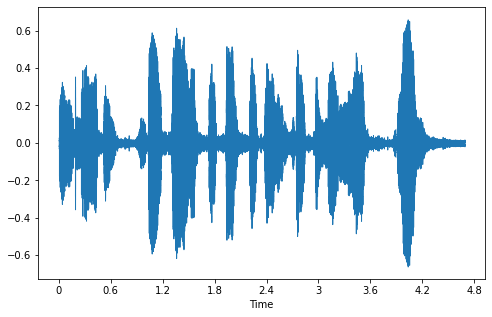

In [7]:
# Sample of Aziz Sancar
plt.figure(figsize=(8,5))
filename = os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[0] + "\\" + subfoldernames[0] + "\\aAUgKYZpZnqwmlvpeYOF.wav"
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [8]:
df = pd.DataFrame(columns=["Filename", "Duration", "Class"])

In [9]:
n_train_samples = 0
for i in range(5):
    for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\"):
        df2 = pd.DataFrame({'Filename': [filename],
                        'Duration' : [lb.get_duration(filename = os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\" + filename)],
                        'Class' : [int(i)]})

        df = pd.concat([df, df2], ignore_index = True, axis = 0)
        n_train_samples += 1

In [10]:
print(str(n_train_samples) + " Training Samples")

3053 Training Samples


In [11]:
df.describe()

,Filename,Duration,Class
count,3053,3053.000000,3053
unique,3053,1.000000,5
top,aAUgKYZpZnqwmlvpeYOF.wav,4.687708,3
freq,1,3053.000000,1008


In [12]:
df.groupby('Class').count()

,Filename,Duration
Class,,
0,554,554
1,561,561
2,591,591
3,1008,1008
4,339,339


# PREPROCESSING AND EXPLORATION

In [13]:
def features_extractor(file, n_features, print_diagram = False):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_features)
    
    if print_diagram:
        fig = plt.figure(figsize=(8,6))
        plt.imshow(mfccs_features)
        plt.title("Mfccs Feature Diagram with {} Features".format(n_features))
        plt.show()
    
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [14]:
filename = os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[0] + "\\" + subfoldernames[0] + "\\aAUgKYZpZnqwmlvpeYOF.wav"

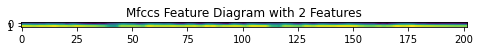

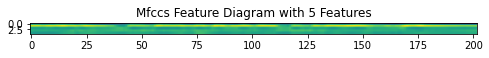

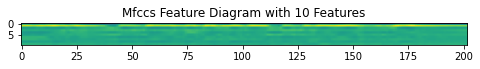

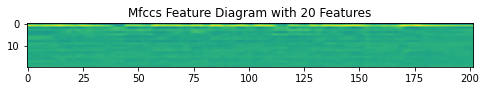

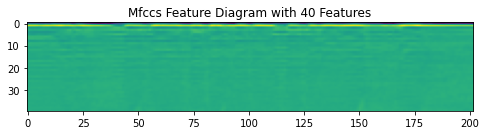

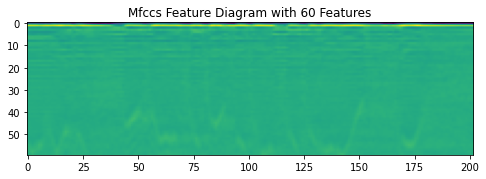

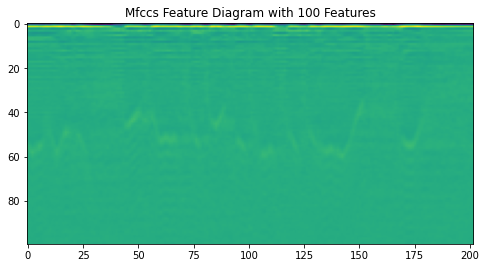

In [15]:
FEATURE_SETTINGS = [2,5,10,20,40,60,100]
for feat in FEATURE_SETTINGS:
    features_extractor(filename, feat, print_diagram = True)
    print("\n")

In [16]:
index = 0
FEATURE_PARAMETER = 100
np_data = np.zeros((3053,FEATURE_PARAMETER))
y = np.zeros(3053)
y = y.astype(np.int64)


for i in range(5):
    for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\"):
        file = (os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\" + filename)
        feature_vector = features_extractor(file, FEATURE_PARAMETER)
        y[index] = df["Class"][index]
        np_data[index] = feature_vector
        index += 1
        print("%" + str(int((index/3053)*100)) + " of the samples' features are extracted.", end="\r")

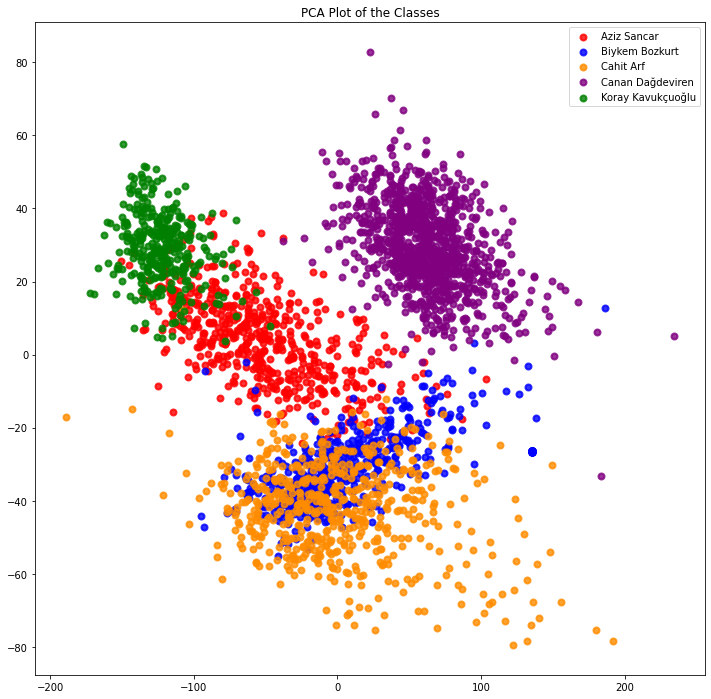

In [17]:
target_names = ["Aziz Sancar", "Biykem Bozkurt", "Cahit Arf", "Canan Dağdeviren", "Koray Kavukçuoğlu"]

pca_np = np.copy(np_data)
pca = PCA(n_components=2)
X_r = pca.fit(pca_np).transform(pca_np)

plt.figure(figsize=(12,12))
colors = ["red", "blue", "darkorange", "purple", "green"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA Plot of the Classes")

plt.show()

# MODEL EVALUATION

## SVC

In [18]:
FEATURE_SETTINGS = [2,5,10,25,50,100]
for feat in FEATURE_SETTINGS:
    print("\n\n---------------------------------------------")
    print(str(feat) + " FEATURES")
    index = 0
    FEATURE_PARAMETER = feat
    np_data = np.zeros((3053,FEATURE_PARAMETER))
    y = np.zeros(3053)
    y = y.astype(np.int64)

    for i in range(5):
        for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\"):
            file = (os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\" + filename)
            feature_vector = features_extractor(file, FEATURE_PARAMETER)
            y[index] = df["Class"][index]
            np_data[index] = feature_vector
            index += 1
            print("%" + str(int((index/3053)*100)) + " of the samples' features are extracted.", end="\r")
         
    X = np.copy(np_data)
    skf = StratifiedKFold(n_splits=5)
    i = 0
    for train, test in skf.split(X, y):
        print("\nFold " + str(i+1))
        clf = SVC()
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        print("Accuracy: " + str(accuracy_score(y_pred, y[test])))
        cm = confusion_matrix(y[test], y_pred)
        print("Confusion Matrix:")
        print(cm)
        #print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))
        i += 1
    



---------------------------------------------
2 FEATURES
%100 of the samples' features are extracted.
Fold 1
Accuracy: 0.7381342062193126
Confusion Matrix:
[[ 75  10   9   7  10]
 [  2  25  58  27   0]
 [  6  11  89  13   0]
 [  2   4   0 195   0]
 [  1   0   0   0  67]]

Fold 2
Accuracy: 0.7332242225859247
Confusion Matrix:
[[ 73  10   8  13   7]
 [  0  30  51  31   0]
 [  9  14  83  12   0]
 [  2   2   0 198   0]
 [  4   0   0   0  64]]

Fold 3
Accuracy: 0.7512274959083469
Confusion Matrix:
[[ 76  13   9   4   9]
 [  1  36  55  20   0]
 [  9  16  86   6   1]
 [  1   4   0 197   0]
 [  4   0   0   0  64]]

Fold 4
Accuracy: 0.7098360655737705
Confusion Matrix:
[[ 78  12   7   8   6]
 [  2  19  58  33   0]
 [  4  26  75  13   0]
 [  1   2   1 198   0]
 [  4   0   0   0  63]]

Fold 5
Accuracy: 0.7278688524590164
Confusion Matrix:
[[ 71  10   8  13   8]
 [  0  33  45  35   0]
 [  8  29  76   4   1]
 [  0   1   0 200   0]
 [  4   0   0   0  64]]


----------------------------------------

## Random Forest Classifier

In [19]:
FEATURE_SETTINGS = [2,5,10,25,50,100]
for feat in FEATURE_SETTINGS:
    print("\n\n---------------------------------------------")
    print(str(feat) + " FEATURES")
    index = 0
    FEATURE_PARAMETER = feat
    np_data = np.zeros((3053,FEATURE_PARAMETER))
    y = np.zeros(3053)
    y = y.astype(np.int64)

    for i in range(5):
        for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\"):
            file = (os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\" + filename)
            feature_vector = features_extractor(file, FEATURE_PARAMETER)
            y[index] = df["Class"][index]
            np_data[index] = feature_vector
            index += 1
            print("%" + str(int((index/3053)*100)) + " of the samples' features are extracted.", end="\r")
         
    X = np.copy(np_data)
    skf = StratifiedKFold(n_splits=5)
    i = 0
    for train, test in skf.split(X, y):
        print("\nFold " + str(i+1))
        clf = RandomForestClassifier(max_depth=1000, random_state=0)
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        print("Accuracy: " + str(accuracy_score(y_pred, y[test])))
        cm = confusion_matrix(y[test], y_pred)
        print("Confusion Matrix:")
        print(cm)
        #print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))
        i += 1
    



---------------------------------------------
2 FEATURES
%100 of the samples' features are extracted.
Fold 1
Accuracy: 0.7545008183306056
Confusion Matrix:
[[ 81   9  10   5   6]
 [  9  62  23  18   0]
 [  7  39  67   6   0]
 [  8   3   4 186   0]
 [  3   0   0   0  65]]

Fold 2
Accuracy: 0.7364975450081833
Confusion Matrix:
[[ 76  11  10   9   5]
 [  4  55  31  22   0]
 [  9  30  70   9   0]
 [  4  11   1 186   0]
 [  5   0   0   0  63]]

Fold 3
Accuracy: 0.7545008183306056
Confusion Matrix:
[[ 87  11   9   2   2]
 [  5  64  29  14   0]
 [  9  32  73   4   0]
 [  2  12   9 179   0]
 [ 10   0   0   0  58]]

Fold 4
Accuracy: 0.7475409836065574
Confusion Matrix:
[[ 79   9  11   8   4]
 [ 12  46  30  24   0]
 [  8  24  77   9   0]
 [  3   4   3 192   0]
 [  5   0   0   0  62]]

Fold 5
Accuracy: 0.7377049180327869
Confusion Matrix:
[[ 74   8  10  12   6]
 [ 11  44  29  29   0]
 [ 10  29  74   5   0]
 [  1   4   4 192   0]
 [  2   0   0   0  66]]


----------------------------------------

# PREDICTION

In [20]:
FEATURE_SETTINGS = [100]
for feat in FEATURE_SETTINGS:
    print("\n\n---------------------------------------------")
    print(str("Extracting ") + str(feat) + " features for train set.")
    index = 0
    FEATURE_PARAMETER = feat
    train_data = np.zeros((3053,FEATURE_PARAMETER))
    y = np.zeros(3053)
    y = y.astype(np.int64)

    for i in range(5):
        for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\"):
            file = (os.getcwd() + "\\turkish-academy-voice-challenge-2022\\" + foldernames[i] + "\\" + subfoldernames[i] + "\\" + filename)
            feature_vector = features_extractor(file, FEATURE_PARAMETER)
            y[index] = df["Class"][index]
            train_data[index] = feature_vector
            index += 1
            print("%" + str(int((index/3053)*100)), end="\r")
    



---------------------------------------------
Extracting 100 features for train set.


In [21]:
test_df = pd.DataFrame(columns=["Filename", "Class"])
n_testing_samples = 0
for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\Test\\"):
    df2 = pd.DataFrame({'Filename': [filename],
                        'Class' : [-42]
                        })

    test_df = pd.concat([test_df, df2], ignore_index = True, axis = 0)
    n_testing_samples += 1

In [22]:
print(str(n_testing_samples) + " Testing Samples")

1000 Testing Samples


In [23]:
FEATURE_SETTINGS = [100]
for feat in FEATURE_SETTINGS:
    print("\n\n---------------------------------------------")
    print(str("Extracting ") + str(feat) + " features for test set.")
    index = 0
    FEATURE_PARAMETER = feat
    test_data = np.zeros((1000,FEATURE_PARAMETER))


    for filename in os.listdir(os.getcwd() + "\\turkish-academy-voice-challenge-2022\\TEST\\"):
        file = (os.getcwd() + "\\turkish-academy-voice-challenge-2022\\TEST\\" + filename)
        feature_vector = features_extractor(file, FEATURE_PARAMETER)
        test_data[index] = feature_vector
        index += 1
        print("%" + str(int((index/1000)*100)), end="\r")    



---------------------------------------------
Extracting 100 features for test set.


In [24]:
clf = SVC(kernel="linear")
clf.fit(train_data, y)
y_pred = clf.predict(test_data)

In [25]:
for i in range(1000):
    test_df["Class"][i] = y_pred[i]

In [26]:
test_df.groupby('Class').count()

,Filename
Class,
0,200
1,200
2,200
3,200
4,200


In [27]:
test_df.to_csv('out.csv', index=False) 